In [3]:
from __future__ import annotations
import jax, jax.numpy as jnp
from jax import jit, vmap
import optax
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, List
from functools import partial
from tqdm.auto import tqdm

Collisions: 3, steps: 201


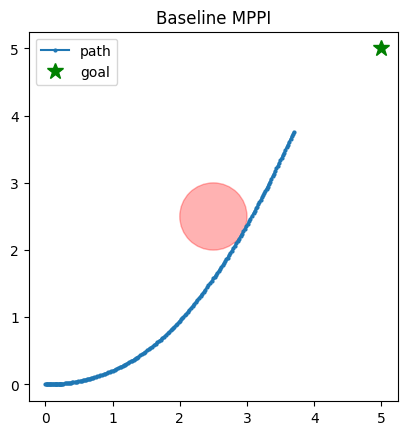

In [6]:
# %% [markdown]
"""
Sections
1. Imports & parameters  
2. System dynamics  
3. Cost function  
4. MPPI controller  
5. Episode runner  
6. Quick demo + plot
"""

CFG: Dict = dict(
    dt=0.1,          # integrator step (s)
    horizon=30,      # control horizon H
    # n_samples=4096,  # number of rollouts N
    n_samples=4102,
    lam=1.0,         # MPPI temperature λ
    goal=jnp.array([5.0, 5.0]),            # goal position (x, y)
    obstacle=jnp.array([2.5, 2.5, 0.5]),   # obstacle (x, y, radius)
)

# %% [markdown]
"## 2  Unicycle dynamics"

# %%
def step_unicycle(state: jnp.ndarray, u: jnp.ndarray, dt: float) -> jnp.ndarray:
    """Euler step for [x, y, θ] given control [v, ω]."""
    x, y, th = state
    v, w = u
    return jnp.array([
        x + dt * v * jnp.cos(th),
        y + dt * v * jnp.sin(th),
        th + dt * w,
    ])

# %% [markdown]
"## 3  Cost function"

# %%

# def traj_cost(states: jnp.ndarray, us: jnp.ndarray, cfg: Dict) -> float:
#     """Simple quadratic goal + control effort + soft obstacle penalty."""
#     goal_cost = jnp.sum((states[-1, :2] - cfg["goal"]) ** 2)
#     ctrl_cost = 0.1 * jnp.sum(us ** 2)
#     ox, oy, r = cfg["obstacle"]
#     d = jnp.linalg.norm(states[:, :2] - jnp.array([ox, oy]), axis=1) - r
#     obs_cost = jnp.sum(jnp.exp(-2.0 * d))
#     return goal_cost + ctrl_cost + obs_cost

# weights in one dict keeps the code tidy
W = dict(goal=1.0,
         heading=0.3,
         effort=0.05,
         obstacle=2.0)

def trajectory_cost(states, controls, cfg):
    xT = states[-1]
    goal_cost = W["goal"] * jnp.sum((xT[:2] - cfg["goal"])**2)

    heading_cost = W["heading"] * (1 - jnp.cos(xT[2] - jnp.arctan2(
                                               cfg["goal"][1]-xT[1],
                                               cfg["goal"][0]-xT[0])))

    effort_cost = W["effort"] * jnp.sum(controls**2)

    # vectorised soft obstacle penalty
    d = jnp.linalg.norm(states[:, :2] - cfg["obstacle"][:2], axis=1) - cfg["obstacle"][2]
    obstacle_cost = W["obstacle"] * jnp.sum(jnp.exp(-2.0 * d))

    return goal_cost + heading_cost + effort_cost + obstacle_cost

# %% [markdown]
"## 4  Minimal MPPI controller"

# %%

def init_mppi(cfg: Dict, key: jax.random.KeyArray):
    """Return a dict with PRNG key + zero nominal controls."""
    return dict(key=key, u_nom=jnp.zeros((cfg["horizon"], 2)))


def mppi_step(x: jnp.ndarray, mppi: Dict, cfg: Dict) -> Tuple[jnp.ndarray, Dict]:
    key, sub = jax.random.split(mppi["key"])
    H, N = cfg["horizon"], cfg["n_samples"]

    noise = 0.3 * jax.random.normal(sub, (N, H, 2))
    u_roll = mppi["u_nom"] + noise    # (N, H, 2)

    def rollout(u_seq):
        s = x
        for k in range(H):
            s = step_unicycle(s, u_seq[k], cfg["dt"])
        return trajectory_cost(jnp.vstack([x, s]), u_seq, cfg)

    costs = jax.vmap(rollout)(u_roll)           # (N,)
    w = jax.nn.softmax(-costs / cfg["lam"])    # (N,)
    u0 = jnp.sum(w[:, None] * u_roll[:, 0], axis=0)

    # shift nominal sequence and append last control
    new_u_nom = jnp.vstack([mppi["u_nom"][1:], u0])
    next_mppi = dict(key=key, u_nom=new_u_nom)
    return u0, next_mppi

# %% [markdown]
"## 5  Episode runner"

# %%

def run_episode(cfg: Dict, max_steps: int = 200, seed: int = 0):
    key = jax.random.PRNGKey(seed)
    state = jnp.array([0.0, 0.0, 0.0])
    mppi = init_mppi(cfg, key)
    traj = [state]
    collisions = 0

    for _ in range(max_steps):
        u, mppi = mppi_step(state, mppi, cfg)
        state = step_unicycle(state, u, cfg["dt"])
        traj.append(state)

        # collision + goal checks
        if jnp.linalg.norm(state[:2] - cfg["obstacle"][:2]) < cfg["obstacle"][2]:
            collisions += 1
        if jnp.linalg.norm(state[:2] - cfg["goal"]) < 0.1:
            break
    return jnp.stack(traj), collisions

# %% [markdown]
"## 6  Plot helper + demo"

# %%

def plot_run(traj: jnp.ndarray, cfg: Dict, title: str = ""):
    xs, ys = traj[:, 0], traj[:, 1]
    fig, ax = plt.subplots()
    ax.plot(xs, ys, "-o", ms=2, label="path")
    ax.plot(*cfg["goal"], "g*", ms=12, label="goal")
    circle = plt.Circle(cfg["obstacle"][:2], cfg["obstacle"][2], color="r", alpha=0.3)
    ax.add_patch(circle)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)
    ax.legend();
    plt.show()


# --- quick demo ---
traj, ncol = run_episode(CFG)
print(f"Collisions: {ncol}, steps: {traj.shape[0]}")
plot_run(traj, CFG, "Baseline MPPI")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\vatta\AppData\Local\Temp\ipykernel_12836\3363011264.py:2: SyntaxWarning: invalid escape sequence '\d'
  """


baseline  – collisions: 0, steps: 201


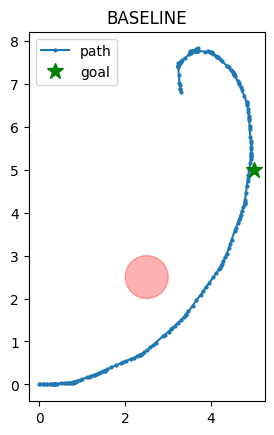

hj        – collisions: 0, steps: 201


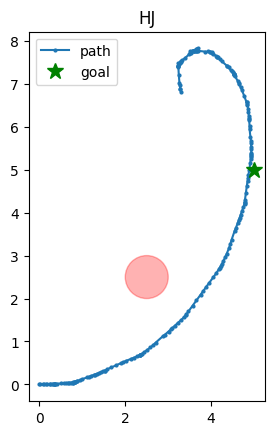

cbf       – collisions: 0, steps: 201


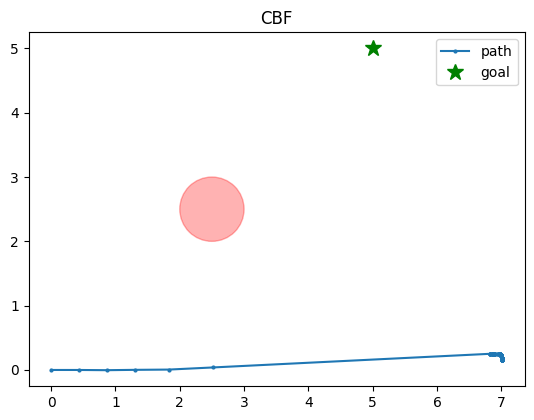

In [5]:
# %% [markdown]
"""
# MPPI with HJ and CBF Safety Filters – Unicycle Demo

* **Hamilton–Jacobi (HJ) shielding** – clamps the forward speed when the obstacle value function is decreasing too quickly.
* **Control Barrier Function (CBF)** – computes the **minimum forward speed** that still meets the barrier constraint `\dot h + αh ≥ 0` and projects the nominal control if necessary.
"""

# %%
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Global configuration dictionary (mutable for quick experiments)
cfg = {
    "dt": 0.1,          # integration step
    "H":  30,           # MPPI horizon
    "N":  2048,         # rollouts per step
    "lam": 1.0,         # MPPI temperature λ
    "goal": jnp.array([5.0, 5.0]),           # (x, y)
    "obs":  jnp.array([2.5, 2.5, 0.5]),      # (x, y, radius)
    "alpha": 1.0,                            # safety gain for HJ / CBF
}

# ----------------------------------------------------------------------
# 2  Dynamics – unicycle Euler step
# ----------------------------------------------------------------------

def unicycle_step(state, control, dt):
    """state = [x, y, θ], control = [v, ω]"""
    x, y, th = state
    v, w = control
    return jnp.array([
        x + dt * v * jnp.cos(th),
        y + dt * v * jnp.sin(th),
        th + dt * w,
    ])

# ----------------------------------------------------------------------
# 3  Cost function for MPPI
# ----------------------------------------------------------------------

def traj_cost(states, controls, c):
    """Quadratic goal + control effort + soft obstacle penalty."""
    goal_cost = jnp.sum((states[-1, :2] - c["goal"]) ** 2)
    ctrl_cost = 0.05 * jnp.sum(controls ** 2)

    ox, oy, r = c["obs"]
    d = jnp.sqrt(jnp.sum((states[:, :2] - jnp.array([ox, oy])) ** 2, axis=-1)) - r
    obs_cost = jnp.sum(jnp.exp(-2.0 * d))
    return goal_cost + ctrl_cost + obs_cost

# ----------------------------------------------------------------------
# 4  Minimal MPPI controller (plain loops, no JIT)
# ----------------------------------------------------------------------


def init_mppi(key, c):
    return {
        "key": key,
        "u_nom": jnp.zeros((c["H"], 2)),  # (H, 2)
    }


def mppi_step(state, mp, c):
    key, sub = jax.random.split(mp["key"])
    noise = 0.3 * jax.random.normal(sub, (c["N"], c["H"], 2))
    u_roll = mp["u_nom"] + noise

    # Rollout + cost
    def rollout(u_seq):
        s = state
        cost = 0.0
        for k in range(c["H"]):
            s = unicycle_step(s, u_seq[k], c["dt"])
            cost += traj_cost(s[None, :], u_seq[k][None, :], c)
        return cost

    costs = jax.vmap(rollout)(u_roll)
    w = jax.nn.softmax(-costs / c["lam"])
    u0 = jnp.sum(w[:, None] * u_roll[:, 0], axis=0)

    # shift nominal window
    mp_next = {
        "key": key,
        "u_nom": jnp.vstack([mp["u_nom"][1:], u0]),
    }
    return u0, mp_next

# ----------------------------------------------------------------------
# 5  Safety filters
# ----------------------------------------------------------------------

# Common helper
def _dist_and_grad(pos, c):
    ox, oy, r = c["obs"]
    vec = pos - jnp.array([ox, oy])
    dist = jnp.linalg.norm(vec)
    grad = vec / (dist + 1e-6)
    h = dist - r  # barrier/value function
    return h, grad

# 5.1 HJ shield (simple clamping)

def hj_safe_control(state, u, c):
    h, grad = _dist_and_grad(state[:2], c)
    # time‑derivative of value for unicycle dynamics (ω neglected)
    v, w = u
    f = jnp.array([v * jnp.cos(state[2]), v * jnp.sin(state[2])])
    dV = grad @ f
    if (h < 0.2) & (dV < -c["alpha"] * h):
        # Too aggressive → scale down forward speed
        v = 0.0
    return jnp.array([v, w])

# 5.2 CBF projection (minimum‑change speed)

def cbf_safe_control(state, u, c):
    h, grad = _dist_and_grad(state[:2], c)
    v_nom, w_nom = u
    dir_vec = jnp.array([jnp.cos(state[2]), jnp.sin(state[2])])
    a = grad @ dir_vec  # ∂h/∂x * f
    # CBF condition: a * v + α h ≥ 0
    v_req = jnp.where(a < 0, -(c["alpha"] * h) / a, 0.0)
    v_safe = jnp.maximum(v_nom, v_req)
    return jnp.array([v_safe, w_nom])

# ----------------------------------------------------------------------
# 6  Episode runner (mode = "baseline" | "hj" | "cbf")
# ----------------------------------------------------------------------

def run_episode(mode="baseline", max_steps=200, seed=0, c=cfg):
    key = jax.random.PRNGKey(seed)
    state = jnp.array([0.0, 0.0, 0.0])
    mp = init_mppi(key, c)
    traj = [state]
    col = 0

    for _ in range(max_steps):
        u, mp = mppi_step(state, mp, c)
        if mode == "hj":
            u = hj_safe_control(state, u, c)
        elif mode == "cbf":
            u = cbf_safe_control(state, u, c)

        state = unicycle_step(state, u, c["dt"])
        traj.append(state)
        if jnp.linalg.norm(state[:2] - c["obs"][:2]) < c["obs"][2]:
            col += 1
        if jnp.linalg.norm(state[:2] - c["goal"]) < 0.1:
            break
    return jnp.stack(traj), col

# ----------------------------------------------------------------------
# 7  Visualisation
# ----------------------------------------------------------------------

def plot_world(traj, c, title=""):
    xs, ys = traj[:, 0], traj[:, 1]
    fig, ax = plt.subplots()
    ax.plot(xs, ys, "-o", ms=2, label="path")
    ax.plot(c["goal"][0], c["goal"][1], "g*", ms=12, label="goal")
    circ = plt.Circle(c["obs"][:2], c["obs"][2], color="r", alpha=0.3)
    ax.add_patch(circ)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)
    ax.legend(); plt.show()

# ----------------------------------------------------------------------
# 8  Demo runs
# ----------------------------------------------------------------------

for mode in ["baseline", "hj", "cbf"]:
    traj, hits = run_episode(mode)
    print(f"{mode:9s} – collisions: {hits}, steps: {len(traj)}")
    plot_world(traj, cfg, title=mode.upper())

In [ ]:
# ### 0.  Imports & environment  #################################################
# #  your Unicycle, obstacle generator, draw_environment() from earlier

# ### 1.  Pre-compute reachability  ##############################################
# V_inf, phi = precompute_hjb(obstacles, goal)          # section 1

# ### 2.  Build MPPI controller  #################################################
# controller = make_controller(phi, goal)               # section 2

# ### 3.  Main closed-loop sim  ##################################################
# state     = jnp.array([2., 3., jnp.pi/4])
# state_hat = state
# data_log  = []

# for step in range(600):                               # 30 s at 50 ms
#     u        = controller.command(state_hat)
#     state    = plant_step(state, u)                   # ground-truth
#     meas     = add_noise(state)                       # sensor model
#     state_hat= ekf_update(state_hat, u, meas)         # simple EKF
#     data_log.append((state, u))

#     if jnp.linalg.norm(state[:2] - jnp.array(goal[:2])) < goal[2]:
#         break

# ### 4.  Evaluation  ############################################################
# metrics = compute_metrics(data_log, phi, goal)        # section 3
# visualise_run(data_log, obstacles, goal)